### The structure of the DQN:
A two hidden layers neural network with 256 and 128 nodes respectively，relu activatin function is applied to all layers except the last layer
### Training Algorithm:
According to this [paper](https://www.nature.com/articles/nature14236), two techniques are used:
1. Experience Replay: A pool of 10,000 ("state","action","reward","next_state","done") is used. Each time 64 random samples are selected from the pool for training
2. Fixed Q-target: two same structure networks are used. A local network is updated every 4 step. A target network is updated by using only 1/1000 of the local network every time 

For each state, the DQN calculates the action values and we minimize the following equation : <br/>
$U(D)[(r+\gamma max_{a'}Q'(s',a';w^{-})-Q(s,a;w))^2] $ <br/>
$U(D)$ stands for the the minibatch we random sample from the experience pool and can break the correlation between the continuously  Q value and the action. For each step, we update $w$ every 4 step and $w^{-}$ is only updated 1/1000 of the $w$ each time. Since updating a guess with a guess can lead to harmful correlation <br/>
This algorithm works, we can see the improvement of the rewards.
### Training hyperparameters:
episodes used for training is 1500, learning rate is 0.0005, minimum epsilon is about 0.01 and the decay rate is 0.995. The number of episodes used to solve the problem is about 1000
### Future ideas:
1. Try different architectures of DQN
2. Try Prioritized Experience Replay
2. Try Dueling DQN

In [4]:
from unityagents import UnityEnvironment
import numpy as np

In [5]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [8]:
import torch
from Agent import Agent
from collections import namedtuple,deque

In [9]:
#training
def train_network(agent,n_episodes=1500,max_t=10000,eps_start=1,eps_end=0.01,eps_decay=0.995):
    """
    n_episodes: maximum number of training episodes
    max_t: maximum number of timesteps per episode
    eps_start: start of epsilon
    eps_end: minimum value of epsilon
    eps_decay: decay factor for epsilon
    """
    scores = []
    scores_window = deque(maxlen=100) # last 100 scores
    eps = eps_start
    
    for i_episode in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state,eps)
            env_info = env.step(action.astype(int))[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score+=reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end,eps_decay*eps)
        
        if i_episode % 100 ==0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode,np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(),'checkpoint.pth')
            
    return scores

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = Agent(action_size=action_size,state_size=state_size,device=device)

In [11]:
scores = train_network(agent)

Episode 100	Average Score: 0.98
Episode 200	Average Score: 4.68
Episode 300	Average Score: 8.15
Episode 400	Average Score: 10.32
Episode 500	Average Score: 12.75
Episode 600	Average Score: 14.15
Episode 700	Average Score: 14.48
Episode 800	Average Score: 14.77
Episode 900	Average Score: 15.05
Episode 1000	Average Score: 14.81
Episode 1100	Average Score: 15.65
Episode 1200	Average Score: 15.60
Episode 1300	Average Score: 15.51
Episode 1400	Average Score: 14.75
Episode 1500	Average Score: 15.12


In [12]:
env.close()

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 0, 'Episode #')

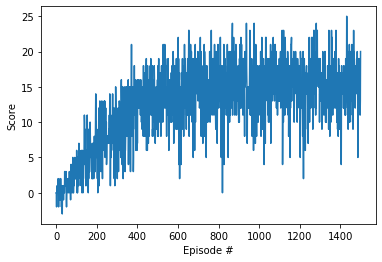

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.ylabel('Score') 
plt.xlabel('Episode #')